## Pycytominer example pipeline
requires scipy=<1.7.3


In [11]:
import pandas as pd
from pycytominer import aggregate
from pycytominer import annotate
from pycytominer import consensus
from pycytominer import feature_select
from pycytominer import normalize

# Import these for plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
# %matplotlib inline


#### Run the preprocessing pipeline

In [12]:
BaseDir = "./results/"

In [13]:
# Import feature data after QC
df = pd.read_csv("{}colo44_QC_filtered.csv".format(BaseDir), sep=";", index_col=0)
# df.head(1)

In [14]:
ListOfData = list(df.columns.values)

# Remove non-data features from the list of features
ListOfFeatures = list(set(ListOfData) - set(['plate_well', 'ImageID']))

In [15]:
# Import Metadata
dfLayout = pd.read_csv("colopaint44-v2-metadata.csv", sep=";", index_col=0)
#dfLayout.head()

In [16]:
# Aggregate: calculate well averages
population_df = aggregate(df, strata="plate_well", features = ListOfFeatures, operation = "median", output_file="none", compute_object_count=False)


well identifier accross plates = strata = 'plate_well'

In [17]:
# Annotate: connect metadata to the feature data
# OBS: metadata will be prefixed with 'Metadata_'
annotated = annotate(population_df, platemap=dfLayout, join_on=["Metadata_plate_well", "plate_well"],add_metadata_id_to_platemap=True, format_broad_cmap=False, clean_cellprofiler=False)

In [18]:
# Normalize: choose between standardize, robustize, mad_robustize, spherize 
normalized = normalize(annotated, features=ListOfFeatures,image_features=False, meta_features="infer", samples="Metadata_pert_type == 'negcon'", method="standardize")

In [19]:
# Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
selected_df = feature_select(normalized, features=ListOfFeatures, operation=["variance_threshold", "correlation_threshold","drop_outliers", "blocklist" ])

In [20]:
# Remove non-data features from the list
ListOfSelectedFeatures = list(selected_df.columns.values)
ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

In [21]:
# Concensus data: average across replicates
# My replicates are those of the same concentration, and same compound.
consensus_df = consensus(selected_df, features=ListOfSelectedFeatures, replicate_columns= ["Metadata_cmpd", "Metadata_cmpd_conc"], operation= "median")

In [22]:
consensus_df.to_csv("{}/colopaint44_consensus_data.csv".format(BaseDir), sep=";")

#### The data is preprocessed, time to plot

from Maris: PCA

In [23]:
pca = PCA(n_components=4)
x = consensus_df.loc[:, ListOfSelectedFeatures[:]].values # Use the latest output after preprocessing: consensus_df
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.rename(
    columns={
        0: "principal component 1",
        1: "principal component 2",
        2: "principal component 3",
        3: "principal component 4",
    },
    inplace=True,
)

In [24]:
# Attach the metadata again
principalDf = principalDf.merge(
    selected_df[ListOfMetadata],
    left_index=True,
    right_index=True,
)

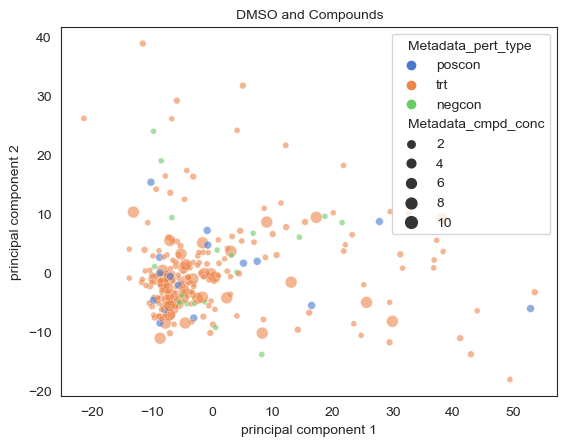

In [25]:
# One of many possible plots
fig = plt.figure()
ax = sns.scatterplot(
    x="principal component 1",
    y="principal component 2",
    hue="Metadata_pert_type",
    data=principalDf,
    size="Metadata_cmpd_conc",
    palette='muted',
    alpha=(0.6),
    marker="o",
    )
ax.set_title("DMSO and Compounds", fontsize=10)
ax.set_facecolor("w")

plt.show()


In [16]:
df_toPlot = selected_df


In [17]:
ConcList = sorted(list(set(df_toPlot["Metadata_cmpd_conc"])))
ConcList.remove(2.5)
df_toPlot['Metadata_cmpd_conc'].loc[(df_toPlot['Metadata_cmpd'] == '[dmso]')] = 100

/var/folders/bx/43bwk4n57dj9446w1ddn_7t40000gn/T/ipykernel_87651/3769912452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toPlot['Metadata_cmpd_conc'].loc[(df_toPlot['Metadata_cmpd'] == '[dmso]')] = 100


In [ ]:
nrrow = 3
nrcol = 2
colors = ["deepskyblue", "gray"]

fig = plt.figure(figsize=(10, 16))
sp = 1
for conc in ConcList:
    dfOneCompound = df_toPlot.loc[
        ((df_toPlot["Metadata_cmpd_conc"] == conc)), ["Metadata_cmpd", "Metadata_cmpd_conc"] + ListOfSelectedFeatures
    ]
    dfDMSO = df_toPlot.loc[
        ((df_toPlot["Metadata_cmpd"] == "[dmso]")), ["Metadata_cmpd", "Metadata_cmpd_conc"] + ListOfSelectedFeatures
    ]
    frames = [dfOneCompound, dfDMSO]
    dfOneCompoundandDMSO = pd.concat(frames)
    dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)

    x = dfOneCompoundandDMSO.loc[:, ListOfSelectedFeatures[:]].values
    pca = PCA(n_components=3)
    x = StandardScaler().fit_transform(x)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents)
    principalDf.rename(
        columns={
            0: "principal component 1",
            1: "principal component 2",
            2: "principal component 3",
        },
        inplace=True,
    )
    principalDf = principalDf.merge(
        dfOneCompoundandDMSO[["Metadata_cmpd", "Metadata_cmpd_conc"]], left_index=True, right_index=True
    )
    # principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')

    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax.set_xlabel("PC 1", fontsize=10)
    ax.set_ylabel("PC 2", fontsize=10)
    ax.spines["left"].set_color("grey")
    ax.spines["bottom"].set_color("grey")
    x
    ax = sns.scatterplot(
        x="principal component 1",
        y="principal component 2",
        hue="Metadata_cmpd_conc",
        data=principalDf,
        palette=colors,
        size="Metadata_cmpd_conc",
        sizes=(25, 15),
        alpha=(0.4),
        marker="o",
    )

    ax.set_title("DMSO and {}".format(conc), fontsize=10)
    ax.set_facecolor("w")
    ax.get_legend().remove()
    sp += 1
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle("PCA scores, DMSO and cons".format(), fontsize=12)
#fig.savefig(
#    "{}/PCA_DMSOandCons.{}".format(OutputDir, figformat), dpi=dpi, bbox_inches="tight"
#)
plt.show()